In [2]:
model_name= 'Burns_CNNBiLSTM'

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys 
sys.path.append('../')

In [5]:
import os
import tensorflow 
import numpy as np
import random

seed_value = 123123
seed_value = None

environment_name = sys.executable.split('/')[-3]
print('Environment:', environment_name)
os.environ[environment_name] = str(seed_value)

np.random.seed(seed_value)
random.seed(seed_value)
tensorflow.random.set_seed(seed_value)

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import tensorflow.compat.v1.keras.backend as K
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
K.set_session(session)

tensorflow.__version__

Environment: biotmpygpu


'2.2.0'

In [6]:
multiple_gpus = [0,1,2,3]
#multiple_gpus = None

In [7]:
import os
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

if multiple_gpus:
    devices = []
    for gpu in multiple_gpus:
        devices.append('/gpu:' + str(gpu))    
    strategy = tensorflow.distribute.MirroredStrategy(devices=devices)

else:
    # Get the GPU device name.
    device_name = tensorflow.test.gpu_device_name()
    # The device name should look like the following:
    if device_name == '/device:GPU:0':
        print('Using GPU: {}'.format(device_name))
    else:
        raise SystemError('GPU device not found')

    os.environ["CUDA_VISIBLE_DEVICES"] = device_name
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

Num GPUs Available:  4
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


In [8]:
from wrappers.bioc_wrapper import bioc_to_docs, bioc_to_relevances
from wrappers.pandas_wrapper import relevances_to_pandas, docs_to_pandasdocs
from preprocessing.dl import DL_preprocessing
from mlearning.dl_models import Burns_CNNBiLSTM
from preprocessing.embeddings import compute_embedding_matrix, glove_embeddings_2
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score, matthews_corrcoef
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score, auc, roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from preprocessing.dl import plot_training_history
from preprocessing.config import Config
from preprocessing.dl import average_precision
from tensorflow.keras.preprocessing import text
from preprocessing.dl import plot_roc_n_pr_curves
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
import seaborn as sns
import pandas as pd
import os
from keras import backend as K
import pickle

[nltk_data] Downloading package stopwords to /home/malves/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/malves/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/malves/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
train_dataset_path = '../datasets/PMtask_Triage_TrainingSet.xml'
test_dataset_path = '../datasets/PMtask_Triage_TestSet.xml'

## Load Data

In [205]:
config = Config(model_name=model_name, seed_value=seed_value)
config.stop_words = set(stopwords.words('english'))           
#config.stop_words = None
config.lower = False               
config.remove_punctuation = False
config.split_by_hyphen = False
config.lemmatization = False           
config.stems = True                      


docs_train = bioc_to_docs(train_dataset_path, config=config)
relevances_train = bioc_to_relevances(train_dataset_path, 'protein-protein')


x_train_df = docs_to_pandasdocs(docs_train)
y_train_df = relevances_to_pandas(x_train_df, relevances_train)

In [206]:
x_train_df

,Document
9685346,<data_structures.document.Document object at 0...
10364224,<data_structures.document.Document object at 0...
10688642,<data_structures.document.Document object at 0...
12059041,<data_structures.document.Document object at 0...
12897151,<data_structures.document.Document object at 0...
...,...
22521144,<data_structures.document.Document object at 0...
25759389,<data_structures.document.Document object at 0...
19887646,<data_structures.document.Document object at 0...
23486661,<data_structures.document.Document object at 0...


In [207]:
y_train_df

9685346     0
10364224    0
10688642    0
12059041    0
12897151    0
           ..
22521144    1
25759389    1
19887646    1
23486661    1
22992732    1
Name: Label, Length: 4082, dtype: int64

In [208]:
x_train_df['Document'][0].title_string

'molecular basi rieger syndrom . analysi pitx2 homeodomain protein activ . rieger syndrom autosomal-domin development disord includ glaucoma mild craniofaci dysmorph human .'

In [209]:
x_train_df['Document'][0].abstract_string

'mutat pitx2 homeobox gene link rieger syndrom . character wild type mutant pitx2 activ use electrophoret mobil shift assay , protein bind , transient transfect assay . pitx2 preferenti bind bicoid homeodomain bind site transactiv report gene contain site . combin pitx2 anoth homeodomain protein , pit-1 , yield synergist 55-fold activ prolactin promot transfect assay . addit pit-1 increas pitx2 bind bicoid element electrophoret mobil shift assay . furthermor , demonstr specif bind pit-1 pitx2 vitro . thu , wild type pitx2 dna bind activ modul protein-protein interact . next studi two rieger mutant . threonin prolin mutat ( t68p ) second helix homeodomain retain dna bind activ appar KD 2-fold reduct bmax . howev , mutant transactiv report gene contain bicoid site . mutant pitx2 protein bind pit-1 , detect synerg prolactin promot . second mutat ( l54q ) highli conserv residu helix 1 homeodomain yield unstabl protein . result provid insight potenti mechan underli development defect rieger

### Embeddings and Deep Learning

In [210]:
#Parameters
config.padding = 'post'            #'pre' -> default; 'post' -> alternative
config.truncating = 'post'         #'pre' -> default; 'post' -> alternative      #####
config.oov_token = 'OOV'

config.epochs = 50
config.batch_size = 32     # e aumentar o batch
config.learning_rate =  0.0001   #experimentar diminuir

config.max_sent_len = 300     #sentences will have a maximum of "max_sent_len" words    #400/500
config.max_nb_words = 100_000      #it will only be considered the top "max_nb_words" words in the dataset

config.embeddings = 'biowordvec'

config.validation_percentage = 10

if not os.path.isdir('./embeddings'):
    !mkdir embeddings

if config.embeddings == 'glove':
    if not os.path.isfile('./embeddings/glove.6B.zip'):
        # !wget -P ./embeddings http://nlp.stanford.edu/data/glove.6B.zip
        !unzip  ./embeddings/glove.6B.zip  -d ./embeddings
    config.embedding_path = './embeddings/glove.6B.200d.txt'
    config.embedding_dim = 200
    config.embedding_format = 'glove'

elif config.embeddings == 'biowordvec':   #200 dimensions
    if not os.path.isfile('./embeddings/biowordvec'):
        !wget -O ./embeddings/biowordvec https://ndownloader.figshare.com/files/12551780
    config.embedding_path = './embeddings/biowordvec'
    config.embedding_dim = 200
    config.embedding_format = 'word2vec'

elif config.embeddings == 'pubmed_pmc':   #200 dimensions
    if not os.path.isfile('./embeddings/pubmed_pmc.bin'):
        !wget -O ./embeddings/pubmed_pmc.bin http://evexdb.org/pmresources/vec-space-models/PubMed-and-PMC-w2v.bin
    config.embedding_path = './embeddings/pubmed_pmc.bin'
    config.embedding_dim = 200
    config.embedding_format = 'word2vec'

elif config.embeddings == 'pubmed_ncbi':   #100 dimensions
    if not os.path.isfile('./embeddings/pubmed_ncbi.bin.gz'):
        !wget -O ./embeddings/pubmed_ncbi.bin.gz ftp://ftp.ncbi.nlm.nih.gov/pub/wilbur/EMBED/pubmed_s100w10_min.bin.gz
    config.embedding_path = './embeddings/pubmed_ncbi.bin.gz'
    config.embedding_dim = 100
    config.embedding_format = 'word2vec'    

else: 
    raise Exception("Please Insert Embeddings Type")

### Keras Callbacks

In [211]:
config.keras_callbacks = True

if config.keras_callbacks:
    config.patience = 5   #early-stopping patience
    checkpoint_path = str(config.model_id_path) + '/checkpoint.hdf5'
    keras_callbacks = [
            EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=config.patience),
            ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    ]
else:
    keras_callbacks=None

In [212]:
#Preprocessing for Training Data

config.tokenizer = text.Tokenizer(num_words=config.max_nb_words, oov_token=config.oov_token)

print(x_train_df['Document'][0].fulltext_string)
for i, tok in enumerate(x_train_df['Document'][0].fulltext_tokens):
    print(i, ': ', tok)

molecular basi rieger syndrom . analysi pitx2 homeodomain protein activ . rieger syndrom autosomal-domin development disord includ glaucoma mild craniofaci dysmorph human . mutat pitx2 homeobox gene link rieger syndrom . character wild type mutant pitx2 activ use electrophoret mobil shift assay , protein bind , transient transfect assay . pitx2 preferenti bind bicoid homeodomain bind site transactiv report gene contain site . combin pitx2 anoth homeodomain protein , pit-1 , yield synergist 55-fold activ prolactin promot transfect assay . addit pit-1 increas pitx2 bind bicoid element electrophoret mobil shift assay . furthermor , demonstr specif bind pit-1 pitx2 vitro . thu , wild type pitx2 dna bind activ modul protein-protein interact . next studi two rieger mutant . threonin prolin mutat ( t68p ) second helix homeodomain retain dna bind activ appar KD 2-fold reduct bmax . howev , mutant transactiv report gene contain bicoid site . mutant pitx2 protein bind pit-1 , detect synerg prola

In [213]:
x_train, y_train, x_val, y_val = DL_preprocessing(x_train_df, y_train_df, 
                                                  config, dataset='train',
                                                  validation_percentage = config.validation_percentage, 
                                                  seed_value=config.seed_value)

Found 25373 unique tokens.
Training set with 3674 samples
Validation set with 408 samples


In [214]:
x_train.shape

(3674, 300)

In [215]:
x_train

array([[1500, 3036,    4, ...,    0,    0,    0],
       [ 269,  947, 1611, ...,    0,    0,    0],
       [ 103,   10,   32, ...,    0,    0,    0],
       ...,
       [2142,   53,   65, ...,    0,    0,    0],
       [ 656,   21, 1900, ...,    0,    0,    0],
       [  27,  153,    5, ...,    0,    0,    0]], dtype=int32)

In [216]:
config.embedding_matrix = compute_embedding_matrix(config, embeddings_format = config.embedding_format)

Creating Embedding Matrix...
Embedding Matrix Created 
------------------------
number of null word embeddings: 6091 in a total of 25373 words (24.01%)
words not found: 6090
e.g. 10 words not found in the index :  ['cockayn' 'provok' 'daytim' 'oddli' 'overaccumul' '7259673' 'ρ'
 'unschedul' 'pof3delta' 'umbil' 'camkiiα' 'lrp5pd2' 'fibrot' 'azotobact'
 'guarante']


In [139]:
protein_index = config.tokenizer.word_index['protein']
print("Dimension of the word embedding for the word 'protein': ", len(config.embedding_matrix[protein_index]))
print("Index for the word 'protein': ", protein_index)

Dimension of the word embedding for the word 'protein':  200
Index for the word 'protein':  2


In [100]:
# with open('saved_config.pkl', 'rb') as fp:
#     config = pickle.load(fp)

# with open('saved_data.pkl', 'rb') as fp:
#     data = pickle.load(fp)
# x_train, y_train, x_val, y_val = data[0], data[1], data[2], data[3]

In [23]:
config.embedding_matrix.shape[0]

30021

In [24]:
len(config.tokenizer.word_index)

30020

In [25]:
#model = Hierarchical_Attention_v3(embedding_matrix, config, seed_value=seed_value)  #=> Best Results until now
if multiple_gpus:
    with strategy.scope():
        model = Burns_CNNBiLSTM(config.embedding_matrix, config, learning_rate=config.learning_rate,
                                               seed_value=config.seed_value) 
else:
    model = Burns_CNNBiLSTM(config.embedding_matrix, config, learning_rate=config.learning_rate,
                                                seed_value=config.seed_value) 
    

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 300, 200)     6004200     input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 300, 200)     0           embedding[0][0]                  
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 300, 16)      16016       dropout[0][0]                    
______________________________________________________________________________________________

In [26]:
history = model.fit(x_train, y_train,
                    epochs=config.epochs,
                    batch_size=config.batch_size,
                    validation_data=(x_val, y_val),
                    callbacks=keras_callbacks)

if config.keras_callbacks:
    model.load_weights(checkpoint_path)

Epoch 1/50
INFO:tensorflow:batch_all_reduce: 14 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 14 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/t

## Evaluation - Training Set

Training Loss: 0.513
Training Accuracy: 0.746


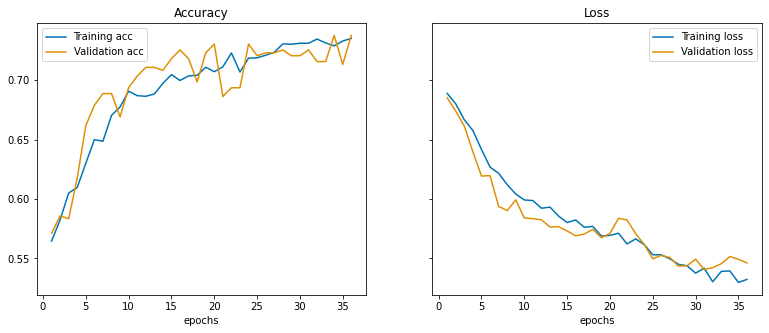

In [27]:
train_loss, config.train_acc = model.evaluate(x_train, y_train, verbose=0)

print('Training Loss: %.3f' % (train_loss))
print('Training Accuracy: %.3f' % (config.train_acc))


plot_training_history(history_dict = history, config=config)

# Test Set

### Load Data

In [28]:
docs_test = bioc_to_docs(test_dataset_path, config=config)
relevances_test = bioc_to_relevances(test_dataset_path, 'protein-protein')

x_test_df = docs_to_pandasdocs(docs_test)
y_test_df = relevances_to_pandas(x_test_df, relevances_test)

x_test, y_test = DL_preprocessing(x_test_df, y_test_df, config, dataset = 'test')


### Predictions

In [29]:
yhat_probs = model.predict(x_test, verbose=0)
yhat_probs = yhat_probs[:, 0]

yhat_classes = np.where(yhat_probs > 0.5, 1, yhat_probs)
yhat_classes = np.where(yhat_classes < 0.5, 0, yhat_classes).astype(np.int64)

## Evaluation - Test Set

### ROC and Precision-Recall curves

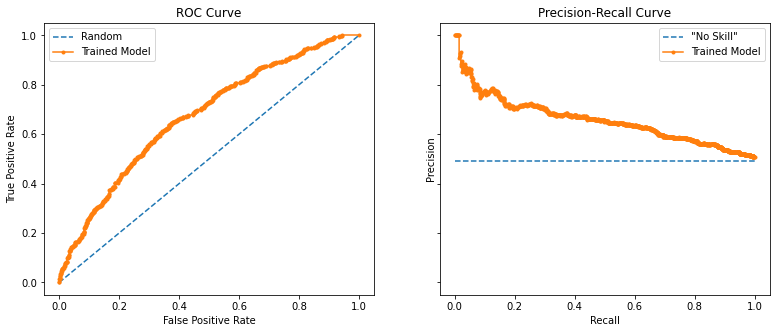

In [30]:
config.test_roc_auc, config.test_pr_auc = plot_roc_n_pr_curves(y_test, yhat_probs,config = config)

In [31]:
config.test_avg_prec  = average_precision(y_test_df, yhat_probs)
print('Average Precision: %f' % config.test_avg_prec)

# accuracy: (tp + tn) / (p + n)
config.test_acc = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % config.test_acc)

# precision tp / (tp + fp)
config.test_prec = precision_score(y_test, yhat_classes)
print('Precision: %f' % config.test_prec)

# recall: tp / (tp + fn)
config.test_recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % config.test_recall)

# f1: 2 tp / (2 tp + fp + fn)
config.test_f1_score = f1_score(y_test, yhat_classes)
print('F1 score: %f' % config.test_f1_score)

# ROC AUC
print('ROC AUC: %f' % config.test_roc_auc)

# PR AUC
print('PR AUC: %f' % config.test_pr_auc)

# kappa
config.test_kappa = cohen_kappa_score(y_test, yhat_classes)
print('Cohens kappa: %f' % config.test_kappa)

config.test_mcc = matthews_corrcoef(y_test, yhat_classes)
print('MCC: %f' % config.test_mcc)

# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print('Confusion Matrix:\n %s \n' % matrix)

config.test_true_neg, config.test_false_pos, config.test_false_neg, config.test_true_pos = confusion_matrix(
                                                                                                y_test, yhat_classes).ravel()

Average Precision: 0.658496
Accuracy: 0.594954
Precision: 0.561165
Recall: 0.821023
F1 score: 0.666667
ROC AUC: 0.674138
PR AUC: 0.657976
Cohens kappa: 0.194665
MCC: 0.218507
Confusion Matrix:
 [[271 452]
 [126 578]] 



### Model ID

In [32]:
config.model_id

'Burns_CNNBiLSTM_22'

### Save config

In [33]:
config.save()

In [34]:
config.path

PosixPath('../pipelines/models/Burns_CNNBiLSTM/Burns_CNNBiLSTM_22/config.txt')

### Write Results

In [35]:
config.write_report()

{'model_id': ['Burns_CNNBiLSTM_22'], 'max_sent_len': [300], 'max_nb_words': [100000], 'max_nb_sentences': [None], 'nmr_sentences': [None], 'embeddings': ['biowordvec'], 'embedding_dim': [200], 'embedding_format': ['word2vec'], 'stop_words': ['Removed'], 'padding': ['post'], 'truncating': ['post'], 'oov_token': ['OOV'], 'lower': ['True'], 'remove_punctuation': ['False'], 'split_by_hyphen': ['True'], 'lemmatization': ['False'], 'stems': ['False'], 'seed_value': [None], 'epochs': [50], 'batch_size': [32], 'learning_rate': [0.0001], 'validation_percentage': [10], 'patience': [5], 'keras_callbacks': ['True'], 'train_acc': [0.7457811832427979], 'train_f1_score': [None], 'test_avg_prec': [0.6584957890767796], 'test_acc': [0.5949544498948843], 'test_prec': [0.5611650485436893], 'test_recall': [0.8210227272727273], 'test_f1_score': [0.6666666666666667], 'test_roc_auc': [0.674138296869106], 'test_pr_auc': [0.6579755939394061], 'test_kappa': [0.19466538043191717], 'test_mcc': [0.21850673408996726

### Model Save

In [36]:
model.save(config.model_id_path / 'model_tf', save_format = 'tf')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ../pipelines/models/Burns_CNNBiLSTM/Burns_CNNBiLSTM_22/model_tf/assets


In [37]:
model_yaml = model.to_yaml()
with open(config.model_id_path / "model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)

In [38]:
import winsound
frequency = 2500  # Set Frequency To 2500 Hertz
duration = 1000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)

ModuleNotFoundError: No module named 'winsound'